# Trading Signal Features

---

### Import Libraries and Dependencies

In [2]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

### Read in Stock Price Data directly from Yahoo as Pandas DataFrame

In [4]:
# Set up End and Start times for data grab
years = 10
end = datetime.now()
start = datetime(end.year - years, end.month, end.day)

# Identify stock data to grab by ticker
ticker = 'AAPL'

In [5]:
# Read in stock data
aapl_df = DataReader(ticker, 'yahoo', start, end)
aapl_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-10,12.258214,12.041786,12.101071,12.230357,448560000.0,10.550527
2011-01-11,12.320000,12.123929,12.317143,12.201429,444108000.0,10.525572
2011-01-12,12.301071,12.214286,12.258929,12.300714,302590400.0,10.611217
2011-01-13,12.380000,12.280357,12.327143,12.345714,296780400.0,10.650034
2011-01-14,12.445714,12.301429,12.353214,12.445714,308840000.0,10.736302


In [6]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2011-01-10 to 2021-01-08
Data columns (total 6 columns):
High         2517 non-null float64
Low          2517 non-null float64
Open         2517 non-null float64
Close        2517 non-null float64
Volume       2517 non-null float64
Adj Close    2517 non-null float64
dtypes: float64(6)
memory usage: 137.6 KB


### Drop NAs and Calculate Daily Returns 

In [6]:
# Drop NAs and calculate daily percent return
aapl_df['daily_return'] = aapl_df['Close'].dropna().pct_change()
aapl_df.head()

,High,Low,Open,Close,Volume,Adj Close,daily_return
Date,,,,,,,
2011-01-10,12.258214,12.041786,12.101071,12.230357,448560000.0,10.550527,NaN
2011-01-11,12.320000,12.123929,12.317143,12.201429,444108000.0,10.525572,-0.002365
2011-01-12,12.301071,12.214286,12.258929,12.300714,302590400.0,10.611217,0.008137
2011-01-13,12.380000,12.280357,12.327143,12.345714,296780400.0,10.650034,0.003658
2011-01-14,12.445714,12.301429,12.353214,12.445714,308840000.0,10.736302,0.008100


In [7]:
aapl_df.describe()

,High,Low,Open,Close,Volume,Adj Close,daily_return
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.000000,2516.000000
mean,36.830372,36.071235,36.450417,36.464820,2.549098e+08,34.772180,0.001108
std,25.121285,24.415771,24.775095,24.783872,2.003844e+08,25.357592,0.017968
min,11.346429,11.089286,11.310000,11.261429,4.544800e+07,9.714678,-0.128647
25%,19.903214,19.491072,19.785713,19.714287,1.144304e+08,17.409834,-0.007207
50%,28.577499,28.027500,28.322500,28.325001,1.833328e+08,26.296860,0.000788
75%,44.437500,43.715000,43.985001,44.142502,3.332000e+08,42.741543,0.010327
max,138.789993,134.339996,138.050003,136.690002,1.880998e+09,136.690002,0.119808


### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [8]:
# Set short and long windows
short_window = 5 # Was 1
long_window = 50 # Was 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
aapl_df['fast_close'] = aapl_df['Close'].ewm(halflife=short_window).mean()
aapl_df['slow_close'] = aapl_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
aapl_df['crossover_long'] = np.where(aapl_df['fast_close'] > aapl_df['slow_close'], 1.0, 0.0)
aapl_df['crossover_short'] = np.where(aapl_df['fast_close'] < aapl_df['slow_close'], -1.0, 0.0)
aapl_df['crossover_signal'] = aapl_df['crossover_long'] + aapl_df['crossover_short']

aapl_df.head()

,High,Low,Open,Close,Volume,Adj Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,,
2011-01-10,12.258214,12.041786,12.101071,12.230357,448560000.0,10.550527,NaN,12.230357,12.230357,0.0,0.0,0.0
2011-01-11,12.320000,12.123929,12.317143,12.201429,444108000.0,10.525572,-0.002365,12.214892,12.215793,0.0,-1.0,-1.0
2011-01-12,12.301071,12.214286,12.258929,12.300714,302590400.0,10.611217,0.008137,12.247544,12.244493,1.0,0.0,1.0
2011-01-13,12.380000,12.280357,12.327143,12.345714,296780400.0,10.650034,0.003658,12.277399,12.270327,1.0,0.0,1.0
2011-01-14,12.445714,12.301429,12.353214,12.445714,308840000.0,10.736302,0.008100,12.320976,12.306384,1.0,0.0,1.0


### Plot Exponential Moving Average of Closing Prices

<AxesSubplot:xlabel='Date'>

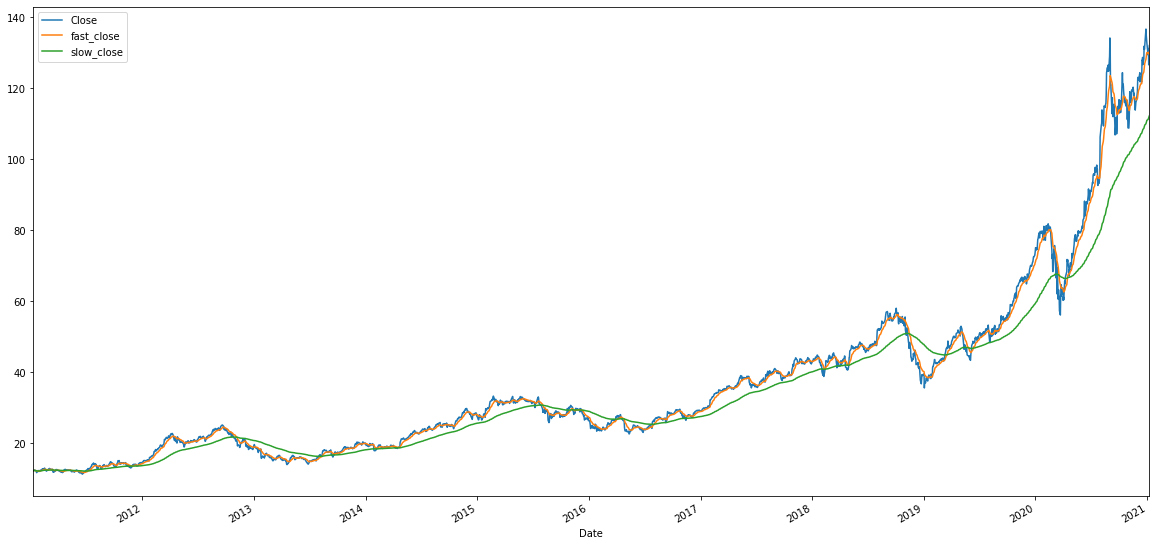

In [9]:
# Plot the EMA of AAPL closing prices
aapl_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [10]:
# Set short and long volatility windows
short_vol_window = 5 # Was 1
long_vol_window = 50 # Was 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
aapl_df['fast_vol'] = aapl_df['daily_return'].ewm(halflife=short_vol_window).std() # Only change from before is change mean() to std()and daily return versus closing price
aapl_df['slow_vol'] = aapl_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
aapl_df['vol_trend_long'] = np.where(aapl_df['fast_vol'] < aapl_df['slow_vol'], 1.0, 0.0)
aapl_df['vol_trend_short'] = np.where(aapl_df['fast_vol'] > aapl_df['slow_vol'], -1.0, 0.0) 
aapl_df['vol_trend_signal'] = aapl_df['vol_trend_long'] + aapl_df['vol_trend_short']

aapl_df.head()

,High,Low,Open,Close,Volume,Adj Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,,
2011-01-10,12.258214,12.041786,12.101071,12.230357,448560000.0,10.550527,NaN,12.230357,12.230357,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2011-01-11,12.320000,12.123929,12.317143,12.201429,444108000.0,10.525572,-0.002365,12.214892,12.215793,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2011-01-12,12.301071,12.214286,12.258929,12.300714,302590400.0,10.611217,0.008137,12.247544,12.244493,1.0,0.0,1.0,0.007426,0.007426,0.0,0.0,0.0
2011-01-13,12.380000,12.280357,12.327143,12.345714,296780400.0,10.650034,0.003658,12.277399,12.270327,1.0,0.0,1.0,0.005072,0.005250,1.0,0.0,1.0
2011-01-14,12.445714,12.301429,12.353214,12.445714,308840000.0,10.736302,0.008100,12.320976,12.306384,1.0,0.0,1.0,0.004713,0.004940,1.0,0.0,1.0


### Plot Exponential Moving Average of Daily Return Volatility

<AxesSubplot:xlabel='Date'>

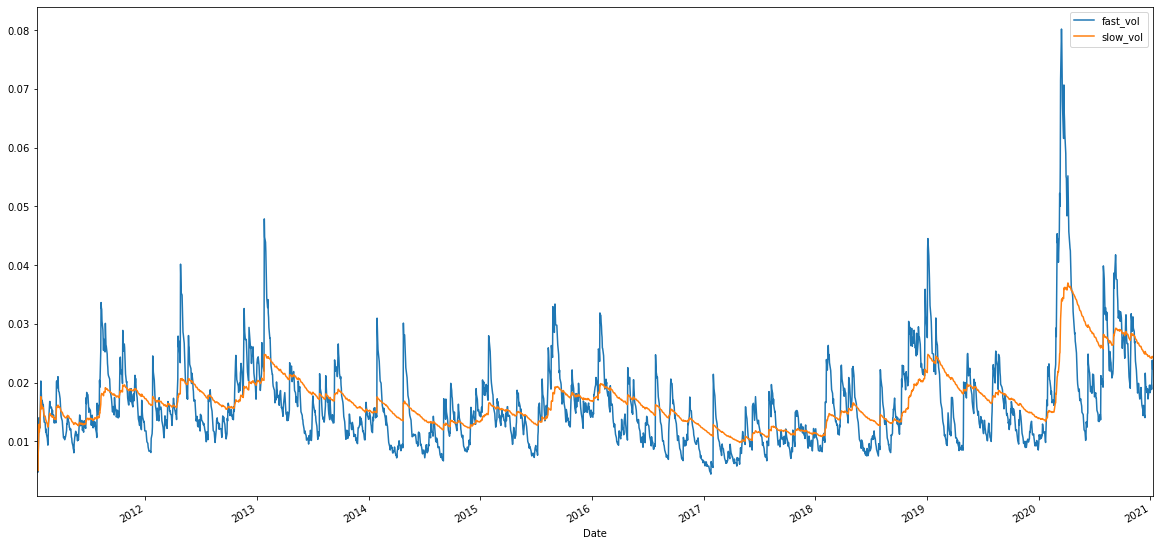

In [11]:
# Plot the EMA of AAPL daily return volatility
aapl_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

### Construct Bollinger Band (Trading Signal, Feature Three)

In [12]:
# Set bollinger band window
bollinger_window = 50 # Was 20 in classroom exercise

# Calculate rolling mean and standard deviation
aapl_df['bollinger_mid_band'] = aapl_df['Close'].rolling(window=bollinger_window).mean()
aapl_df['bollinger_std'] = aapl_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band (= 1 standard deviation)
aapl_df['bollinger_upper_band']  = aapl_df['bollinger_mid_band'] + (aapl_df['bollinger_std'] * 1)
aapl_df['bollinger_lower_band']  = aapl_df['bollinger_mid_band'] - (aapl_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
aapl_df['bollinger_long'] = np.where(aapl_df['Close'] < aapl_df['bollinger_lower_band'], 1.0, 0.0)
aapl_df['bollinger_short'] = np.where(aapl_df['Close'] > aapl_df['bollinger_upper_band'], -1.0, 0.0)
aapl_df['bollinger_signal'] = aapl_df['bollinger_long'] + aapl_df['bollinger_short']

aapl_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,daily_return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.970001,0.007712,126.968241,109.620225,1.0,...,1.0,0.0,1.0,119.7370,4.190395,123.927395,115.546605,0.0,-1.0,-1.0
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.690002,0.035766,128.226717,109.992902,1.0,...,1.0,0.0,1.0,120.0566,4.491252,124.547852,115.565348,0.0,-1.0,-1.0
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.869995,-0.013315,129.086686,110.335392,1.0,...,1.0,0.0,1.0,120.3736,4.611354,124.984954,115.762246,0.0,-1.0,-1.0
2020-12-30,135.990005,133.399994,135.580002,133.720001,96452100.0,133.720001,-0.008527,129.686466,110.657335,1.0,...,1.0,0.0,1.0,120.7284,4.765221,125.493621,115.963179,0.0,-1.0,-1.0
2020-12-31,134.740005,131.720001,134.080002,132.690002,98990400.0,132.690002,-0.007703,130.075272,110.960666,1.0,...,1.0,0.0,1.0,121.0320,4.807043,125.839043,116.224957,0.0,-1.0,-1.0
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,129.410004,-0.024719,129.989153,111.214663,1.0,...,1.0,0.0,1.0,121.2828,4.683888,125.966688,116.598912,0.0,-1.0,-1.0
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,131.009995,0.012364,130.121301,111.487191,1.0,...,1.0,0.0,1.0,121.5880,4.519370,126.107370,117.068629,0.0,-1.0,-1.0
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,126.599998,-0.033662,129.665470,111.695254,1.0,...,1.0,0.0,1.0,121.8192,4.405512,126.224712,117.413688,0.0,-1.0,-1.0
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,130.919998,0.034123,129.827868,111.959926,1.0,...,1.0,0.0,1.0,122.1366,4.314964,126.451564,117.821636,0.0,-1.0,-1.0


### Plot Bollinger Bands

<AxesSubplot:xlabel='Date'>

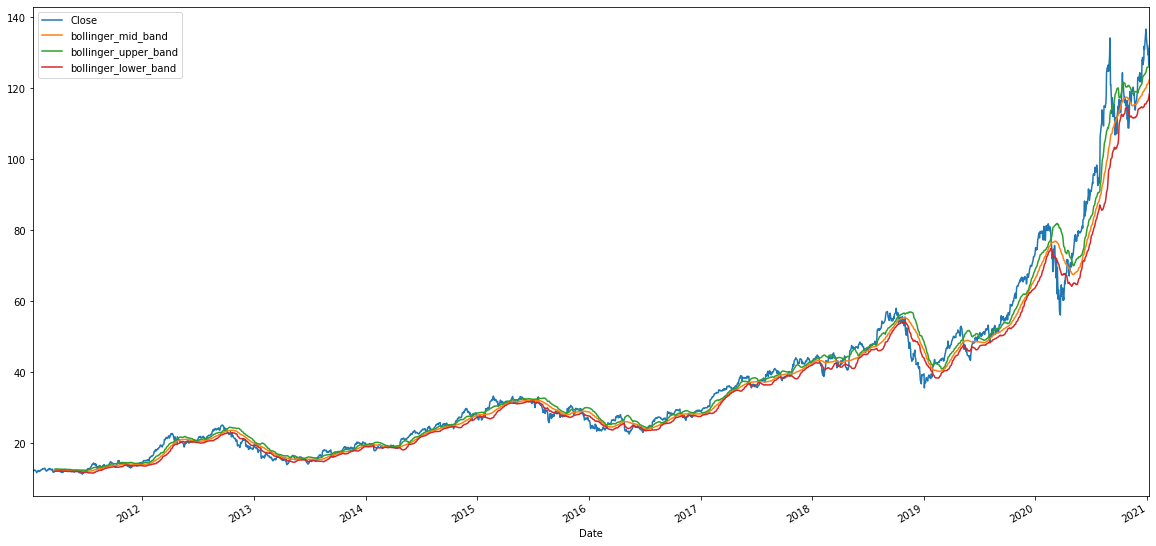

In [13]:
# Plot the Bollinger Bands for AAPL closing prices
aapl_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [14]:
aapl_df.to_csv(r'trading_signals.csv')